In [3]:
# import soundfile as sf
# !pip install numpy
# !pip install librosa
# !pip install pandas
# !pip install matplotlib
# !pip install --upgrade setuptools
# !pip install dtw --user
# !py -m pip install --upgrade pip setuptools wheel
import numpy as np
import os
import librosa
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [4]:
#First loading both the user and the singer wav files

def audio_signal(path):
    audio, sr = librosa.load(path)
    return audio.astype(np.float32), sr

user_audio, sr1 = audio_signal('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/wav/cover1.wav')
og_audio, sr2 = audio_signal('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/wav/og1.wav')

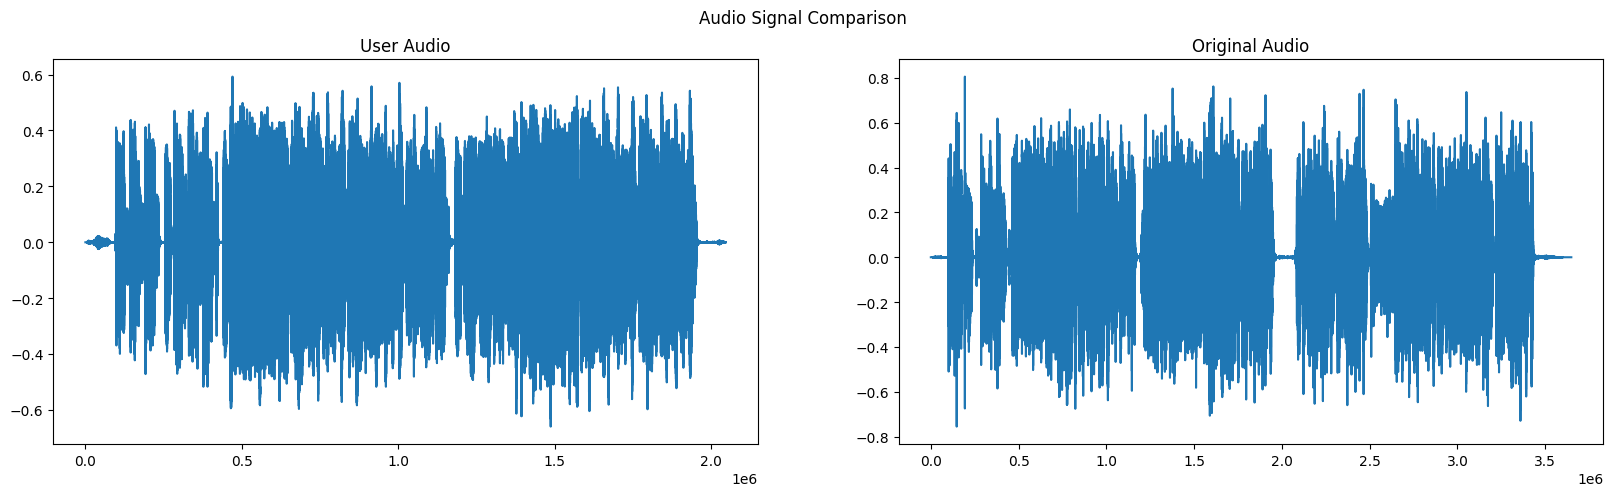

In [13]:
#Plotting thee audio signals
figure, ax = plt.subplots(1,2, figsize=(20,5))
figure.suptitle('Audio Signal Comparison')
ax[0].plot(user_audio)
ax[0].set_title('User Audio')
ax[1].plot(og_audio)
ax[1].set_title('Original Audio')
plt.show()

Since we are only working with the vocals of both the user and the original singer audio, we don't have a beat to synchronize the original and the user audio. Thus, we will use the MFCCs to align the audio 

### Preprocessing codecell : 

In [14]:
#We first trim the silent part from the audio signal at the beginning and the end
def trim_audio(audio):
    return librosa.effects.trim(audio)[0]

#Resampling the audio signals
def resample_audio(audio, sr, target_sr):
    return librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)

#Extracting a subset of the audio signals for faster computation
def subset_audio(audio, sr):
    return audio[0: round(3.5*sr)]

#Dividing the song into frames 
def frames(audio):
    frame_length = 2205
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=512)
    return np.transpose(frames)

#Windowing a frame
def windowing(frame):
    #Using the hamm window
    return scipy.signal.get_window('hamming', frame.shape[0])

#L2 norm
def l2_norm(vector):
    return np.linalg.norm(vector, ord=2)

#L6 norm
def l6_norm(vector):
    return np.linalg.norm(vector, ord=6)

#DTW algorithm
# def DTW(vec1, vec2):
#     _, wp = librosa.sequence.dtw(vec1, vec2, backtrack=True)
#     nan_rows = np.isnan(wp[:, 0] | np.isnan(wp[:, 1]))  # Check for NaN in either column
#     # Remove rows with NaN (optional)
#     wp_filtered = wp[~nan_rows, :]
#     return wp[0], wp[1]

user_audio = trim_audio(user_audio)
og_audio = trim_audio(og_audio)

user_audio = resample_audio(user_audio, sr1, 22050)
sr1 = 22050
og_audio = resample_audio(og_audio, sr2, 22050)
sr2 = 22050

user_audio = subset_audio(user_audio, 22050)
print(user_audio.shape)
og_audio = subset_audio(og_audio, 22050)
print(og_audio.shape)

user_frames = frames(user_audio)
og_frames = frames(og_audio)
print(user_frames.shape)
print(og_frames.shape)


(77175,)
(77175,)
(147, 2205)
(147, 2205)


### Pitch detection functions

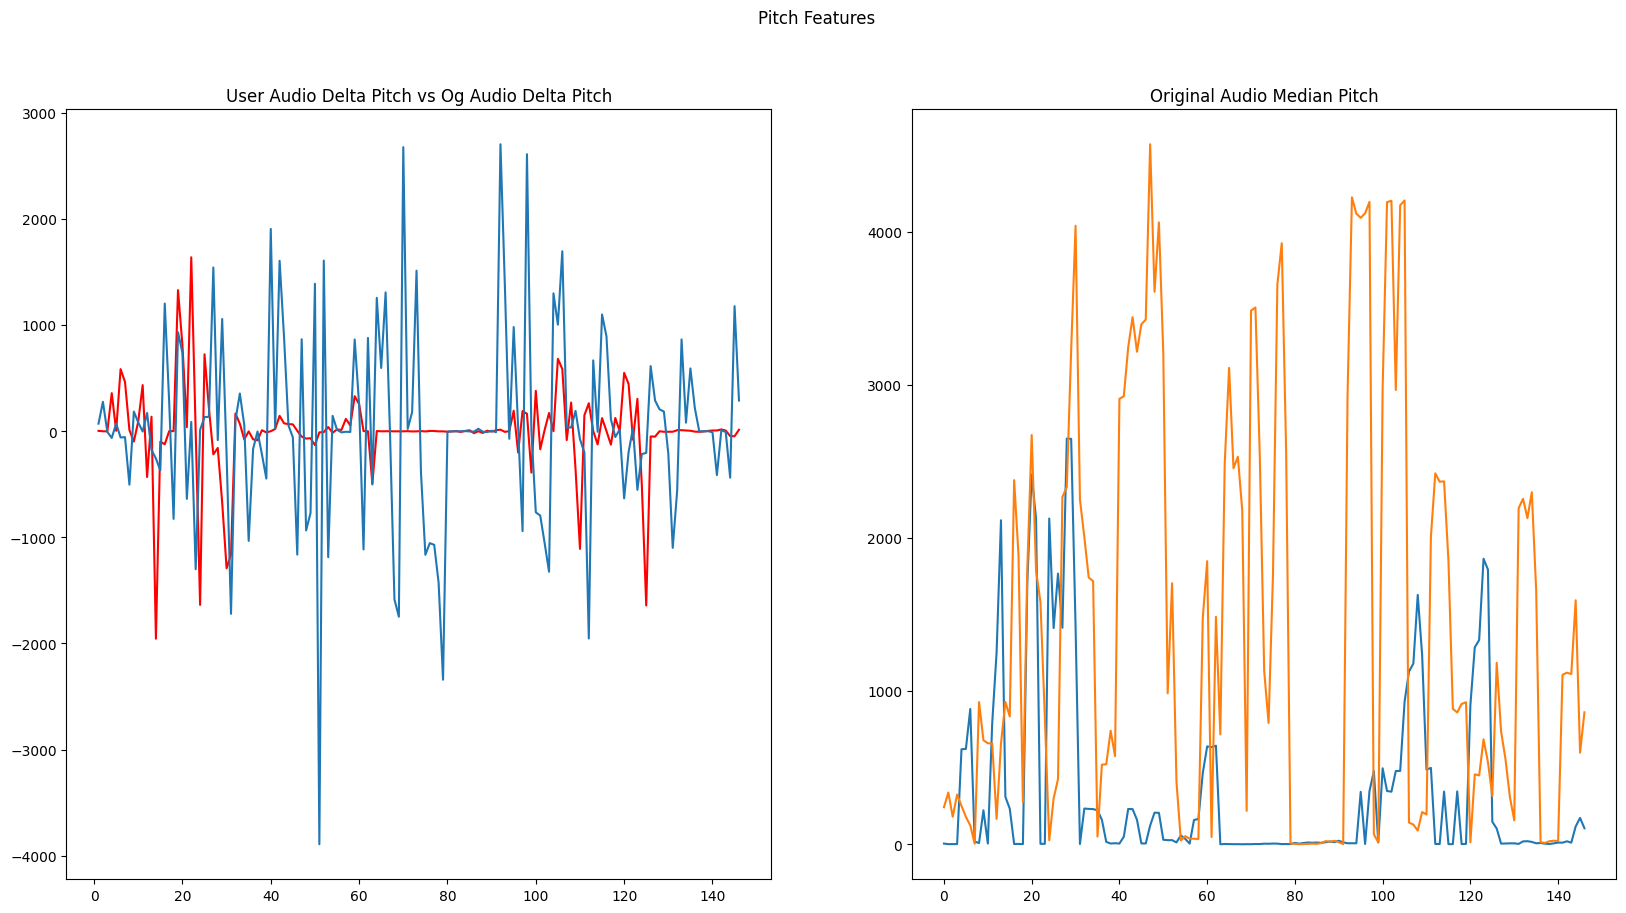

In [15]:
def pitch_detection(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

def med_sub_p(pitch_vector):
    median = np.median(pitch_vector)
    return pitch_vector - median

def pitch_features(frames, sr):
    l2n = []
    pmed=[]
    for frame in frames:
        pitch_vector = pitch_detection(frame, sr)
        # print(frame.shape, pitch_vector.shape)
        l2n.append(l2_norm(pitch_vector))
        medsubp = med_sub_p(pitch_vector)
        pmed.append(l2_norm(medsubp))
    l2n = pd.Series(l2n)
    pitch_der = l2n.diff()
    return np.array(pitch_der), np.array(pmed)

# def pitch_new(audio, sr):
#     pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sr)
#     # get indexes of the maximum value in each time slice
#     max_indexes = np.argmax(magnitudes, axis=0)
#     # get the pitches of the max indexes per time slice
#     pitches = pitches[max_indexes, range(magnitudes.shape[1])]
#     l2norm = l2_norm(pitches)
#     return l2norm

user_delta_p, user_pmed = pitch_features(user_frames, sr1)
og_delta_p, og_pmed = pitch_features(og_frames, sr2)

#Plotting the pitch features
figure, ax = plt.subplots(1,2, figsize=(20,10))
figure.suptitle('Pitch Features')
ax[0].plot(user_delta_p, color='red')
ax[0].set_title('User Audio Delta Pitch vs Og Audio Delta Pitch')
ax[0].plot(og_delta_p)
ax[1].plot(user_pmed)
ax[1].set_title('User Audio Median Pitch vs Og Audio Median Pitch')
ax[1].plot(og_pmed)
ax[1].set_title('Original Audio Median Pitch')
plt.show()

### Pitch Implementation

In [6]:
def pitch_err(user_frames, sr1, og_frames, sr2):
    user_delta_p, user_median_p = pitch_features(user_frames, sr1)
    og_delta_p, og_median_p = pitch_features(og_frames, sr2)
    #Plot the og and user delta p but connect the aligned points with a line
    # figure, ax = plt.subplots(1,2,figsize=(20,10))
    # figure.suptitle('Pitch Features')
    # ax[0].plot(user_delta_p)
    # ax[0].set_title('User Audio Delta Pitch vs Og Audio Delta Pitch')
    # ax[0].plot(og_delta_p)
    # #PLot the markers for the aligned points
    # ax[0].plot(user_der_index, og_der_index, color='black', marker='o')
    # ax[1].plot(user_median_p)
    # ax[1].set_title('User Audio Median Pitch vs Og Audio Median Pitch')
    # ax[1].plot(og_median_p)
    # ax[1].plot(user_med_index, og_med_index, color='black')
    # plt.show()
    #Finding the euclidean distance between the two pitch features
    
delta_p_err, med_p_err = pitch_err(user_frames, sr1, og_frames, sr2)
print(delta_p_err)
print(med_p_err)
    

TypeError: cannot unpack non-iterable NoneType object

### Rhythm detection functions and Speech

In [ ]:
#For rhythm features, we will use the mfcc features for every frame

def mfcc_features(frames, sr):
    mfccs = []
    for frame in frames:
        # print(frame.reshape(-1,1).shape)
        mfcc = librosa.feature.mfcc(y=frame, sr=sr, n_mfcc=13, hop_length=220, n_fft=2048)
        mfccs.append(mfcc)
    return np.array(mfccs)

user_mfccs = mfcc_features(user_frames, sr1)
og_mfccs = mfcc_features(og_frames, sr2)

print(user_mfccs.shape)
print(og_mfccs.shape)


(147, 13, 11)
(147, 13, 11)


### Rhythm Implementation

In [ ]:
#First we find the euclidean errors for each of the mfcc feature 
def mfcc_err(user_mfccs, og_mfccs):
    errors = []
    print(user_mfccs.shape)
    print(og_mfccs.shape)
    for i in range(user_mfccs.shape[0]):
        #Separate the errors for each of the 13 mfcc features
        errors.append(user_mfccs[i] - og_mfccs[i])
    error = np.array(errors).T
    print(error.shape)
    #mse
    error = np.mean(error**2, axis=0)
    return np.array(error)

mfcc_errors = mfcc_err(user_mfccs, og_mfccs)
print(mfcc_errors)


(147, 13, 11)
(147, 13, 11)
(11, 13, 147)
[[4.7966992e+03 9.7556293e+02 1.6501685e+03 ... 2.0038527e+04
  2.0333936e+04 2.0071201e+04]
 [3.9013004e+04 2.3131205e+04 2.8562418e+04 ... 5.2070737e+03
  4.7606929e+03 3.4813562e+03]
 [9.1962383e+03 6.6699512e+03 5.5386655e+03 ... 6.4339575e+03
  3.7060874e+03 2.8693245e+03]
 ...
 [7.0534790e+01 2.1368666e+01 3.2439813e+02 ... 9.9684808e+02
  8.7196753e+02 7.4932556e+02]
 [5.6446411e+02 4.4149481e+02 5.6453882e+02 ... 5.9030060e+02
  7.8286890e+02 1.1523517e+03]
 [9.6027832e+01 1.3008519e+02 9.9972603e+01 ... 7.4019244e+02
  8.7583081e+02 1.0734122e+03]]


### Range of Pitch

In [ ]:
def rop(user_frames, sr):
    l2n = []
    for frame in user_frames:
        pitch_vector = pitch_detection(frame, sr)
        # print(frame.shape, pitch_vector.shape)
        l2n.append(l2_norm(pitch_vector))
    l2n = np.array(l2n)
    return l2n.max() - l2n.min()

rop_user = rop(user_frames, sr1)
rop_og = rop(og_frames, sr2)

print(rop_user)
print(rop_og)

4194.1714
7584.997


### Volume of the audio

In [13]:
#Function for short term log energy
def short_term_log_energy(frames):
    energy = []
    for frame in frames:
        energy.append(np.log(np.sum(frame**2)))
    return np.array(energy)

def energy_err(user_frames, og_frames):
    user_energy = short_term_log_energy(user_frames)
    print(user_energy.shape)
    og_energy = short_term_log_energy(og_frames)
    return (user_energy - og_energy).sum()

energy_errors = energy_err(user_frames, og_frames)
print(energy_errors)

(147,)
589.16943


SPR functions

In [19]:
def calculate_intensity(audio_data, sample_rate, window_func='hann'):

  audio_data = librosa.util.normalize(audio_data)  # Normalize audio
  stft = librosa.stft(audio_data, window=window_func)
  intensity_db = librosa.power_to_db(np.abs(stft) ** 2, ref=np.max(np.abs(stft)))
  return intensity_db

def find_peak_intensity(intensity_db, freq_range, sample_rate):
 
  nyquist = sample_rate / 2
  min_idx = int(freq_range[0] / nyquist * len(intensity_db))
  max_idx = int(freq_range[1] / nyquist * len(intensity_db))
  return np.max(intensity_db[min_idx:max_idx])

def singing_power_ratio(audio_data, sample_rate):

  intensity_db = calculate_intensity(audio_data, sample_rate)
  low_intensity_db = find_peak_intensity(intensity_db, (0, 2000), sample_rate)
  high_intensity_db = find_peak_intensity(intensity_db, (2000, 4000), sample_rate)
  
  
  if high_intensity_db == np.inf: 
    return float('inf')
  else:
    return 10 * np.log10(np.exp(low_intensity_db / 10) / np.exp(high_intensity_db / 10))  

ratio = singing_power_ratio(og_audio, sr1)
print(f"Singing power ratio: {ratio}")

Singing power ratio: 6.805012694753312
